In [33]:
from qiskit import QuantumCircuit,transpile 
from qiskit_aer import AerSimulator,StatevectorSimulator,QasmSimulator
from qiskit.circuit.library import RZGate,RXGate 
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector,plot_distribution,plot_histogram

In [3]:
def quantum_embedding(phi,theta_params):
    qc=QuantumCircuit(1)
    qc.h(0)
    qc.s(0)

    qc.rx(phi,0)
    qc.rz(theta_params[0],0)

    qc.rx(phi,0)
    qc.rz(theta_params[1],0)

    qc.rx(phi,0)
    qc.rz(theta_params[2],0)
    qc.rx(phi,0)

    return qc

In [4]:
phi_a = np.linspace(-np.pi, np.pi, 5)  # Class A data
phi_b = np.linspace(-np.pi, np.pi, 5)  # Class B data
theta_params = [np.pi/8, np.pi/4, np.pi/2]

In [5]:
backend=AerSimulator(method="statevector")

qc_a = quantum_embedding(phi_a[0], theta_params)
qc_b = quantum_embedding(phi_b[0], theta_params)



job_a=backend.run(qc_a,shots=10000)
job_b=backend.run(qc_b,shots=10000)

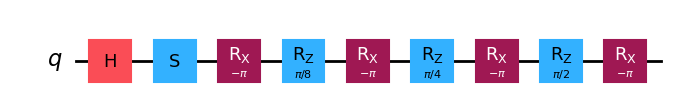

In [6]:
qc_a.draw(output="mpl")

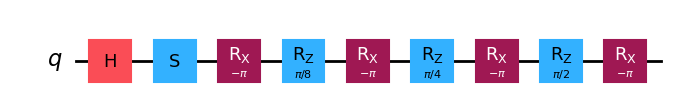

In [7]:
qc_b.draw(output="mpl")

In [8]:
result_a = job_a.result()
result_b = job_b.result()

s_a=Statevector.from_instruction(qc_a)
s_b=Statevector.from_instruction(qc_b)



In [9]:
print("Statevector for class A:")
s_a.draw(output="latex")

Statevector for class A:


<IPython.core.display.Latex object>

In [10]:

print("Statevector for class B:", s_b)

s_b.draw(output="latex")


Statevector for class B: Statevector([0.5879378 +0.39284748j, 0.39284748+0.5879378j ],
            dims=(2,))


<IPython.core.display.Latex object>

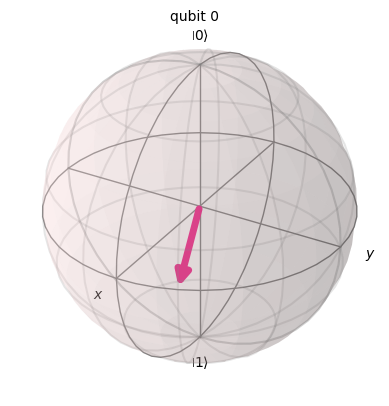

In [11]:

plot_bloch_multivector(s_a)

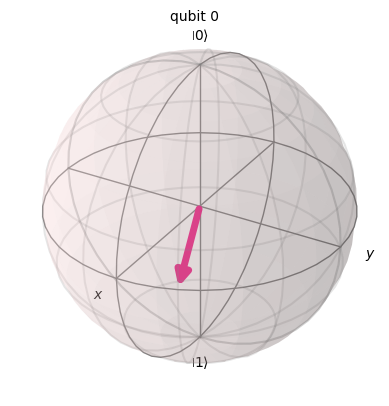

In [12]:
plot_bloch_multivector(s_b)

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Create a SWAP test circuit for two quantum circuits qc1 and qc2
def swap_test(qc1, qc2):
    q = QuantumRegister(3)
    c = ClassicalRegister(1)  # Register to store the measurement
    qc = QuantumCircuit(q, c)

    qc.compose(qc1, qubits=[1], inplace=True)
    qc.compose(qc2, qubits=[2], inplace=True)
    
    qc.h(0)
    
    # Apply the controlled-SWAP gate between qubit 1 and qubit 2, controlled by qubit 0
    qc.cswap(0, 1, 2)
    
    # Apply another Hadamard gate to the control qubit
    qc.h(0)
    
    # Measure the control qubit
    qc.measure(0, 0)
    
    return qc


In [14]:
def execute_test(qc):
    backend=QasmSimulator()
    transpiled_circ=transpile(qc,backend)
    job=backend.run(transpiled_circ,shots=1024)
    counts=job.result().get_counts()
    return counts.get('0',0)/1024

In [15]:
def cost_function(embeddings_a, embeddings_b, theta_params):
    cost = 0
    
    # Intra-class overlap within class A
    for i in range(len(embeddings_a)):
        for j in range(i, len(embeddings_a)):
            qc_a1 = quantum_embedding(embeddings_a[i], theta_params)
            qc_a2 = quantum_embedding(embeddings_a[j], theta_params)
            swap_circuit = swap_test(qc_a1, qc_a2)
            result = execute_test(swap_circuit)
            cost -= result  # Maximize intra-class similarity
    
    # Intra-class overlap within class B
    for i in range(len(embeddings_b)):
        for j in range(i, len(embeddings_b)):
            qc_b1 = quantum_embedding(embeddings_b[i], theta_params)
            qc_b2 = quantum_embedding(embeddings_b[j], theta_params)
            swap_circuit = swap_test(qc_b1, qc_b2)
            result = execute_test(swap_circuit)
            cost -= result
    
    # Inter-class overlap (between class A and class B)
    for i in range(len(embeddings_a)):
        for j in range(len(embeddings_b)):
            qc_a = quantum_embedding(embeddings_a[i], theta_params)
            qc_b = quantum_embedding(embeddings_b[j], theta_params)
            swap_circuit = swap_test(qc_a, qc_b)
            result = execute_test(swap_circuit)
            cost += result  # Minimize inter-class similarity

    return cost

In [16]:
from scipy.optimize import minimize

# Objective function for optimization
def objective(theta_params, embeddings_a, embeddings_b):
    return cost_function(embeddings_a, embeddings_b, theta_params)

# Example embeddings (replace with real data if necessary)
embeddings_a = np.linspace(-np.pi, np.pi, 5)  # Class A data
embeddings_b = np.linspace(-np.pi, np.pi, 5)  # Class B data

# Initial guess for theta parameters
theta_init = np.random.rand(3)

# Minimize the cost function using gradient descent (BFGS method)
result = minimize(objective, theta_init, args=(embeddings_a, embeddings_b), method='COBYLA')
optimized_theta = result.x

print("Optimized Parameters:", optimized_theta)

Optimized Parameters: [1.35489221 1.12066058 0.11133584]


In [17]:
final_cost = cost_function(embeddings_a, embeddings_b, optimized_theta)
print("Final Cost after Optimization:", final_cost)

Final Cost after Optimization: -4.9375


In [18]:
from qiskit.quantum_info import hellinger_distance,state_fidelity,hellinger_fidelity

In [19]:
def non_uniform_state():
    qc=QuantumCircuit(2)

    params=np.random.random(size=(3,))
    
    qc.h(0)
    qc.ry(params[0],1)
    qc.rz(params[1],0)

    qc.ry(params[2],1)
    qc.cx(0,1)

    
    return qc

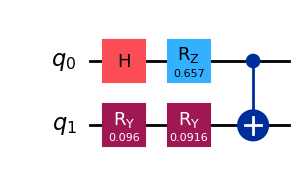

In [20]:
circ=non_uniform_state()
circ.draw(output="mpl")

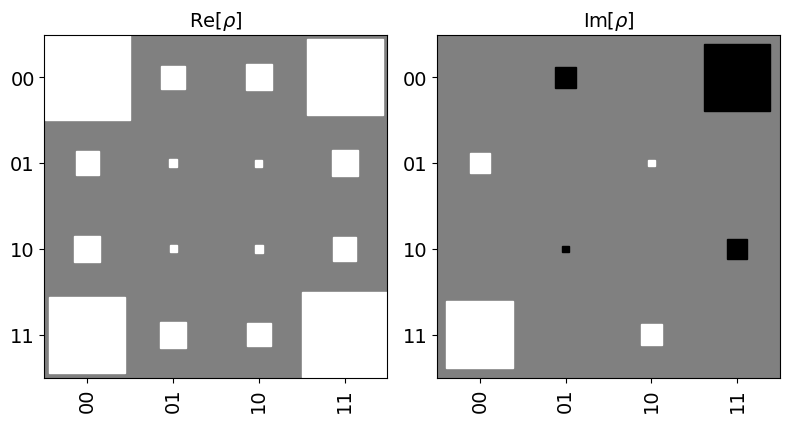

In [21]:
sv=Statevector(circ)
sv.draw(output="hinton")

In [22]:
def simulate_non_uniform(qc):
    circ.remove_final_measurements()
    circ.measure_all()
    backend=StatevectorSimulator()
    job=backend.run(qc,shots=1024)
    counts_sv=job.result().get_counts()

    return counts_sv

In [24]:
print(simulate_non_uniform(circ))
Result_dict["Qasm"]=simulate_non_uniform(circ)

{'00': 510, '11': 505, '01': 7, '10': 2}


In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_ibm_runtime import Session 

In [26]:
service=QiskitRuntimeService()


Selected backend= aer_simulator


In [27]:
def real_backend(qc,backend):
    qc.remove_final_measurements()
    qc.measure_all()

    pm=generate_preset_pass_manager(backend=backend,optimization_level=1)
    transpiled_circ=pm.run(qc)

    with Session(service=service,backend=backend) as session:
        sampler=Sampler(mode=backend)
        job_sampler=sampler.run(pubs=[transpiled_circ],shots=1024)

        results=job_sampler.result()[0]

        counts=results.data.meas.get_counts()

        print("Counts from real backend: ", counts)
        return counts


In [121]:
real_backend(circ,backend)

Counts from real backend:  {'00': 399, '10': 130, '01': 121, '11': 374}


{'00': 399, '10': 130, '01': 121, '11': 374}

In [122]:
back_list=["ibm_kyiv","ibm_sherbrooke","ibm_brisbane"]
Result_dict={}

for i in back_list:
    backend=service.backend(i)
    count_backend=real_backend(circ,backend)

    Result_dict[i]=count_backend
print(Result_dict)

Counts from real backend:  {'00': 390, '11': 365, '10': 122, '01': 147}


In [1]:
Result_dict={}
Result_dict["ibm_kyiv"]={'00': 390, '11': 365, '10': 122, '01': 147}

In [28]:
Result_dict

{'ibm_kyiv': {'00': 390, '11': 365, '10': 122, '01': 147},
 'Qasm': {'00': 490, '11': 524, '10': 4, '01': 6}}

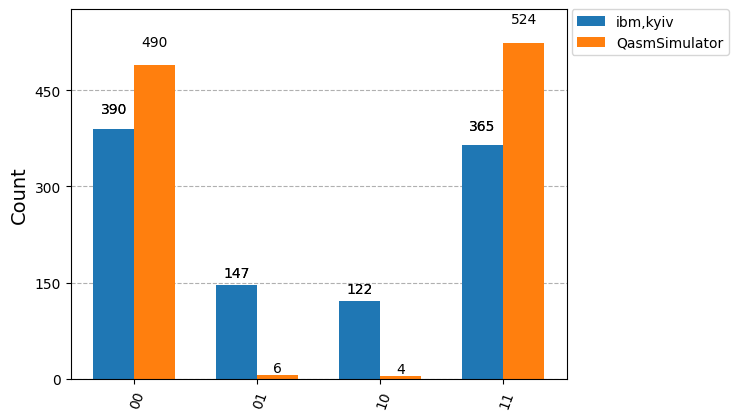

In [36]:
plot_histogram([Result_dict["ibm_kyiv"],Result_dict["Qasm"]],legend=["ibm,kyiv","QasmSimulator"])
